In [50]:
import pandas as pd
import numpy as np
import plotly.graph_objects
import plotly.express
import scipy.stats as st
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px

In [2]:
wine_df = pd.read_csv('winequality-red.csv')

In [3]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# **1D SELECTION ALGORYTHMS**

**LINEAR CORRELATION**

In [4]:
features = [feat for feat in wine_df.columns if feat != 'quality']

In [5]:
lin_corr_array = np.zeros((len(features),))

In [6]:
def get_correlation(feature, response):
    return np.sum((feature - np.mean(feature)) * (response - np.mean(response))) / np.sqrt(np.sum((feature - np.mean(feature)) ** 2) * np.sum((response - np.mean(response)) ** 2))

In [7]:
for i in range(len(features)):
    lin_corr_array[i] = get_correlation(wine_df[features[i]], wine_df['quality'])

In [8]:
lin_corr_array

array([ 0.12405165, -0.39055778,  0.22637251,  0.01373164, -0.12890656,
       -0.05065606, -0.18510029, -0.17491923, -0.05773139,  0.25139708,
        0.47616632])

**MUTUAL INFORMATION TECHNIQUE**

In [9]:
mutual_info_array = np.zeros((len(features),))
mutual_info_array_mine = np.zeros((len(features),))

In [10]:
def get_mut_info(feature, response):
    unique_feature_val = np.unique(feature)
    unique_response_val = np.unique(response)
    MI = 0
    for feat_val in unique_feature_val:
        for resp_val in unique_response_val:
            mut_probability = feature[(feature == feat_val) & (response == resp_val)].shape[0]
            if mut_probability == 0:
                continue
            feat_probability = feature[feature == feat_val].shape[0]
            resp_probability = response[response == resp_val].shape[0]
            MI += mut_probability * np.log2(mut_probability / (feat_probability * resp_probability))
    return MI

In [11]:
for i in range(len(features)):
    mutual_info_array_mine[i] = get_mut_info(wine_df[features[i]], wine_df['quality'])
mutual_info_array_mine

array([-16629.60664821, -16391.85666733, -16641.2566096 , -16706.9401968 ,
       -16547.45999419, -16796.3235191 , -16496.03994059, -15812.03177048,
       -16695.54060945, -16506.63415496, -16437.68298264])

In [12]:
mutual_info_array = mir(wine_df[features], wine_df['quality'], n_neighbors=2)
mutual_info_array

array([0.05502137, 0.11713227, 0.04526234, 0.02142737, 0.01270287,
       0.06801762, 0.10154625, 0.07119738, 0.00213888, 0.09686328,
       0.22702239])

# **DIMENSION REGRESSION** 

**RANDOM PROJECTION**

In [31]:
pca = PCA(n_components=2)
pca.fit(wine_df.loc[:, ~wine_df.columns.isin(['quality'])])

PCA(n_components=2)

In [40]:
np.std(pca.components_[0])**2

0.07918075216046362

In [72]:
pca.explained_variance_

array([1133.80707551,   57.93541077])

In [41]:
pca.components_[0]

array([-6.13247431e-03,  3.84465551e-04,  1.70902595e-04,  8.64894648e-03,
        6.37307290e-05,  2.18857434e-01,  9.75678369e-01,  3.72498542e-06,
       -2.68008619e-04,  2.23381730e-04, -6.35846721e-03])

In [42]:
d_sum = 0
for i in wine_df.columns:
    if i != 'quality':
        d_sum += np.std(wine_df[i]) ** 2
print(d_sum)

1197.047922329165


In [71]:
new_features = pd.DataFrame(pca.transform(wine_df.loc[:, ~wine_df.columns.isin(['quality'])]))
np.std(new_features.values, axis=0) ** 2

array([1133.09800292,   57.8991785 ])

In [73]:
plot_data = pd.concat((new_features, wine_df['quality'].astype('str')), axis=1)

In [74]:
plot_data.columns = ['x1', 'x2', 'y']

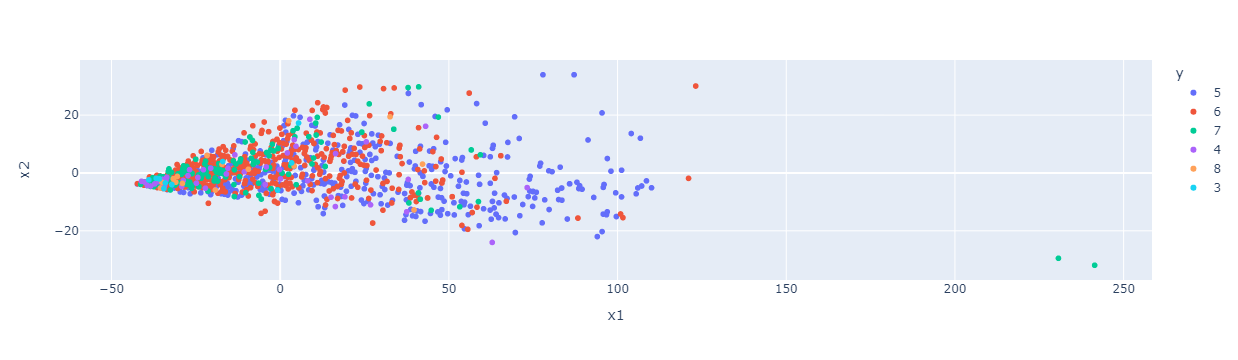

In [75]:
fig = px.scatter(data_frame=plot_data, x='x1', y='x2', color='y')
fig.show()

# **ДЗ**

**1. отобрать лучшую модель для обучения для датасета с оригинальными фичами, подобрать гиперпараметры**
**2. применить PCA что б отобрать 2, 3 и 4 и сравнить с результатом пункта 1**
**3. Применить отбор признаков ADD-DEL**
**4. sne, t-sne, попробовать реализовать**